# Sistema de recomendación

Voy a aprovechar la competencia de Telecom ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

## Aims:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

## Caveats:
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).

## Archives:

- https://drive.google.com/file/d/1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt/view?usp=sharing

- https://drive.google.com/file/d/1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt/view?usp=sharing

Grupo 1
  - Agustin Diaz
  - Gisela Brunetto
  - Juan Carlos Jimenez garcia
  - Juan Manuel
  - Matias Culasso
  - Pablo Sebastian Chiesa
  - Maxi Sanchez
 

---------------------------------

----------------
Importamos las librerias

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

-----------------
Cargamos el Drive y los dataset

In [87]:
from google.colab import drive # La usamos para montar nuestra unidad de Google Drive
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
!gdown https://drive.google.com/file/d/1g4_xcTQM4vZqiuUJqYHJGbFp91RSiTpG/view?usp=sharing --fuzzy
train='train.csv'
df=pd.read_csv(train, parse_dates=['tunein', 'tuneout'])

!gdown https://drive.google.com/file/d/1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt/view?usp=sharing --fuzzy
metadata= 'metadata.csv'
df_metadatos=pd.read_csv(metadata,  encoding="utf-8", sep=';', parse_dates=["create_date", "modify_date", "start_vod_date", "end_vod_date"])

Downloading...
From: https://drive.google.com/uc?id=1g4_xcTQM4vZqiuUJqYHJGbFp91RSiTpG
To: /content/train.csv
100% 251M/251M [00:01<00:00, 246MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt
To: /content/metadata.csv
100% 21.3M/21.3M [00:00<00:00, 134MB/s] 


-------------------
Analisis de los dataset

Comenzamos analizando el dataset con los datos de interacciones

In [ ]:
df.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0


Este datataset comprende  observaciones de las interacciones de los clientes con los productos de una plataforma de streaming (Cablevision Flow, o Flow de aqui en adelante). Las columnas codifican para:

* **customer_id**: código de identificación de cada cliente de Flow (puede tener asociados uno o más account_id)
* **account_id**: código de identificación de cada perfil de Flow (se corresponde con un único customer_id)
* **device_type**: indica el tipo de dispositivo desde el que se efectuó la visualización. Las categorías posibles son:
    
    CLOUD: cliente web
    
    PHONE: teléfono celular
    
    STATIONARY: smart TV
    
    STB: "set-top box", es decir el decodificador
    
    TABLET

* **asset_id**: código de identificación de cada activo (video) disponible en la plataforma
* **tunein**: fecha y hora de inicio de cada visualización
* **tuneout**: fecha y hora de finalización de cada visualización
* **resume**: variable dummy que indica si se reanuda un consumo anterior del mismo asset_id

In [ ]:
df.account_id.nunique()

113881

--------
Metadatos

In [ ]:
df_metadatos.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01 10:18:15+00:00,2019-01-26 06:37:18+00:00,2017-12-01 00:00:00+00:00,2020-12-01 23:59:59+00:00
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19 20:58:15+00:00,2019-09-17 19:02:03+00:00,2017-12-15 00:00:00+00:00,2022-12-14 23:59:59+00:00
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16 13:51:07+00:00,2020-04-28 14:16:38+00:00,2018-01-25 00:00:00+00:00,2020-12-01 23:59:59+00:00
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26 11:58:44+00:00,2019-11-15 03:00:23+00:00,2018-05-27 00:00:00+00:00,2021-04-30 23:59:59+00:00
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03 20:07:24+00:00,2020-04-09 04:37:29+00:00,2019-05-02 00:00:00+00:00,2020-12-31 23:59:59+00:00


Contiene la metadata asociada a cada uno de los contenidos alojados en Flow. Las variables incluidas son:

- **asset_id**: código de identificación de cada activo (video) disponible en Flow.
- **content_id**: código de identificación que agrupa los distintos asset_id asociados a un mismo contenido (por ejemplo, cada episodio de una misma serie tiene su propio asset_id,mientras que la serie se identifica con un content_id único).
- **title**: título.
- **reduced_title**: título reducido.
- **episode_title**: título del episodio (válido para contenidos episódicos, como las series).
- **show_type**: tipo de show - las categorías son autorreferenciales con excepción de “Rolling”, que indica que se trata de una serie incompleta, y “Web”, la cual remite a contenidos pensados íntegramente en formato digital (series web). 
- **released_year**: año de lanzamiento.
- **country_of_origin**: país de origen. Esta expresado con el código de dos letras. 
- **category**: categoría o género al que pertenece el contenido. Es importante notar que puede haber una o más palabras claves. 
- **keywords**: palabras clave o tags asociadas al contenido. Es importante notar que puede haber una o más palabras claves. 
- **description**: descripción (sinopsis).
- **reduced_desc**: descripción (sinopsis) reducida
- **cast_first_name**: nombre y apellido de los actores y actrices principales
- **credits_first_name**: nombre y apellido del director 
- **run_time_min**: duración total, expresada en minutos.
- **audience**: audiencia target.
- **made_for_tv**: variable dummy que indica si el contenido fue hecho para TV
- **close_caption**: variable dummy que indica si el contenido posee subtítulos.
- **sex_rating**: variable dummy que indica si el contenido tiene escenas de sexo explícitas.
- **violence_rating**: variable dummy que indica si el contenido tiene escenas de violencia explícitas.
- **language_rating**: variable dummy que indica si el contenido posee lenguaje que puede ser considerado ofensivo o inapropiado
- **dialog_rating**: variable dummy que indica si el contenido posee diálogos que pueden ser considerado ofensivos o inapropiados.
- **fv_rating**: variable dummy que indica si el contenido tiene rating de FV, que corresponde a público infantil con violencia ficticia.
- **pay_per_view**: variable dummy que indica si se trata de un alquiler.
- **pack_premium_1**: variable dummy que indica si se trata de un contenido exclusivo del pack premium 1.
- **pack_premium_2**: variable dummy que indica si se trata de un contenido exclusivo del pack premium 2.
- **create_date**: fecha de creación del activo.
- **modify_date**: fecha de modificación del activo.
- **start_vod_date**: fecha desde la cual el activo se encuentra disponible en la plataforma.
- **end_vod_date**: fecha de finalización de la disponibilidad del activo en la plataforma.

In [89]:
df.asset_id.nunique()

23987

---
---
---

Realizamos la unión de ambos datasets ("merge") a partir de la columna "asset_id"

In [90]:
Data = df.merge(df_metadatos, on='asset_id', how='left')

In [91]:
Data = Data[['account_id', 'asset_id', 'tunein', 'tuneout', 'content_id', 'title', 'end_vod_date']]

In [ ]:
Data.head()

,account_id,asset_id,tunein,tuneout,content_id,title,end_vod_date
0,90627,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,2040.0,T:5 Ep:08 This is Us,2021-06-30 23:59:59+00:00
1,90627,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,2040.0,T:5 Ep:10 This is Us,2021-06-30 23:59:59+00:00
2,3387,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,1983.0,T:1 Ep:02 Big Little Lies,2021-03-28 23:59:00+00:00
3,3387,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1983.0,T:1 Ep:02 Big Little Lies,2021-03-28 23:59:00+00:00
4,3387,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,729.0,T:1 Ep:02 Dime quiÃ©n soy,2021-03-28 23:59:00+00:00


#### Exploratory data analysis

Para el EDA vamos a conservar todas las columnas pero trabajaremos con una muestra aleatoria del datatset.

-----

In [92]:
df_eda = Data.sample(160000)

**Que cantidad de usuarios y cuentas tenemos en la muestra?**

In [ ]:
df_eda.customer_id.nunique(), df_eda.account_id.nunique()

(54834, 55143)

Son cifras muy parecidas, sugiriendo que muchos usuarios tienen una cuenta y pocos tienen 2 o más cuentas.

In [ ]:
accounts = df_eda.groupby('customer_id').agg({'account_id': 'nunique'})

accounts.value_counts("account_id")

account_id
1    54529
2      301
3        4
dtype: int64

La mayoria de los usuarios en nuestra muestra posee 1 sola cuenta y muy pocos 2 o 3 cuentas.

**Desde donde se conectan más los usuarios?**

In [ ]:
devices = df_eda.groupby('device_type')
devices["device_type"].value_counts().sort_values(ascending=False)

device_type   device_type 
STB           STB             130927
STATIONARY    STATIONARY        9933
PHONE         PHONE             9451
CLOUD_CLIENT  CLOUD_CLIENT      7576
TABLET        TABLET            2113
Name: device_type, dtype: int64

La gran mayoria de los usuarios utilizan el decodificador de FLow para acceder a los productos, seguido por los que acceden mediante sus smart tv, cuya cantidad es similar a los usuarios que acceden a los productos mediante telefonos.

**Cuales son los productos más vistos?**

In [ ]:
productos = df_eda.groupby('asset_id')
productos["asset_id"].value_counts().sort_values(ascending=False)

asset_id  asset_id
32732.0   32732.0     627
16738.0   16738.0     532
15610.0   15610.0     432
30357.0   30357.0     430
4239.0    4239.0      416
                     ... 
25374.0   25374.0       1
25372.0   25372.0       1
15132.0   15132.0       1
25367.0   25367.0       1
21483.0   21483.0       1
Name: asset_id, Length: 16932, dtype: int64

El producto más visto fue el identificado por el id "32732" con 627 visualizaciones en nuestra muestra.

In [ ]:
df_metadatos[df_metadatos['asset_id'] == 32732.0]

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
27384,32732,1316.0,T:7 Ep:44 Peppa Pig,Peppa_Pig_T7_E44,El nuevo camino del Señor Toribio,TV,2016.0,US,Infantil/Dibujos Animados,"Educativo,Animales",...,N,N,N,N,N,N,2020-12-17 23:56:51+00:00,2021-03-11 14:05:02+00:00,2020-12-01 00:00:00+00:00,2021-04-01 23:59:59+00:00


El producto mas visto corresponde a una serie infantil educativa, producida en Estados Unidos y lanzada en el año 2016.

In [ ]:
productos["asset_id"].value_counts().median()

4.0

SI bien existen contenidos muy populares, la mayoria de los productos alojados en Flow es visto 4 veces.

**Cuantos productos en consumen los usuarios?**

In [ ]:
vistos_cuenta = df_eda.groupby('account_id').agg({'asset_id': 'nunique'})

vistos_cuenta.mean(), vistos_cuenta.max(), vistos_cuenta.min()

(asset_id    2.814011
 dtype: float64, asset_id    84
 dtype: int64, asset_id    1
 dtype: int64)

En promedio, las cuenta ven 3 productos distintos. La cuenta que más contenidos consumió vio 84 productos y la que menos solo 1 producto.

**Que tipo de productos consume cada tipo audiéncia**?

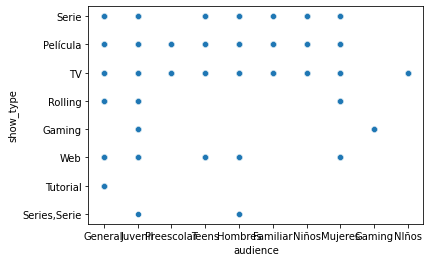

In [93]:
sns.scatterplot(data = df_metadatos, x="audience", y = "show_type")

In [111]:
audience = df_metadatos.groupby('audience')['show_type'].value_counts()

audience    show_type   
Familiar    Película         322
            TV               114
            Serie              2
Gaming      Gaming             4
General     Serie           6163
            TV              4812
            Película        2452
            Web              151
            Rolling           56
            Tutorial          21
Hombres     Serie            573
            TV               547
            Película         433
            Web               13
            Series,Serie       2
Juvenil     Serie           1419
            Web             1145
            Gaming           840
            TV               676
            Película         357
            Rolling           15
            Series,Serie       1
Mujeres     Serie           2292
            TV              1740
            Película         300
            Rolling          204
            Web               16
NIños       TV                36
Niños       TV              2206
            Pelícu

EL grafico y tabla indican que el consumo de los productos en Flow es principalmente para audiencias generales, mujeres, preescolares y niños. Los datos parecen indicar que a los adultos y adolescentes se les suele ofrecer Series en primer lugar y a los preescolares y niños se los asocia con TV. Es importante notar que existe un numero muy bajo de oferta de consumo particulare, como el Gaming, indicando que en Flow se consumen muchos productos generales y no tan segmentados. 

**Que categorias de productos consume cada audiéncia?**

In [121]:
df_metadatos.groupby('')['category'].value_counts()

audience  category          
Familiar  Infantil              106
          Infantil/Animación    102
          Aventura/Fantasía      51
          Infantil/Comedia       25
          Comedia                23
                               ... 
Teens     Animación/Aventura      1
          Animación/Fantasía      1
          Drama/Musical           1
          Infantil/Acción         1
          Infantil/Fantasía       1
Name: category, Length: 419, dtype: int64

Aqui podemos concluir que mucho del contenido infantil es ofrecido a cuentas asociadas al target de audiencia familiar.

In [122]:
df_metadatos.groupby('audience')['category'].value_counts().sort_values(ascending=False).head(20)

audience    category                    
Mujeres     Drama/Romance                   1948
Preescolar  Infantil/Dibujos Animados       1934
Teens       Infantil/Dibujos Animados       1783
Niños       Infantil/Dibujos Animados       1738
General     Drama                           1198
Juvenil     Comedia                         1040
            Entretenimiento                 1012
General     Interés General/Periodístico     878
            Comedia/Romance                  823
Teens       Infantil/Comedia                 803
General     Drama/Romance                    799
            Drama/Crimen                     658
            Comedia                          654
            Documental                       531
            Reality                          492
Juvenil     Entretenimiento/Competencia      476
Hombres     Interés General/Deporte          468
General     Drama/Suspenso                   448
Niños       Infantil                         416
Mujeres     Reality         

Por otro lado, las audiencias "mujeres" se les ofrece productos del tipo Drama/Romance, a los pre-adolescentes  Dibujos animados, a los adolescentes Comedia y a los target de interes general productos periodisticos.

**Cuales son las Keywords asociadas a los consumos de cada audiéncia?**

In [124]:
key_per_cat = df_metadatos.groupby('audience').agg({'keywords': 'unique'})
key_per_cat['nunique'] = key_per_cat['keywords'].apply(lambda x: len(x))
key_per_cat.sort_values(by='nunique', ascending=False).head(20)

,keywords,nunique
audience,,
General,"[Trastornos,Médicos,Tragicómica,Telenovela,Enf...",2720
Juvenil,"[Criaturas,Plagas,Adolescentes,Fantasía,Video ...",436
Hombres,"[Mafia,Venganza,Latinoamérica,Mujeres, Espiona...",406
Mujeres,"[Europa,Melodrama,Época,60s, Espectáculos,Actu...",363
Familiar,"[Criaturas,Aventuras,Fantasía, Animales,Europa...",248
Teens,"[Dimensiones,Aventuras,Mascotas,Dreamworks,Fam...",172
Niños,"[Animales,Aventuras,Dinero, Animales,Mascotas,...",138
Preescolar,"[Amigos,Aventuras,Autos, Superhéroes,De Libros...",58
Gaming,"[Gaming,Competencia,Videojuegos,Adolescentes]",1


Los productos con target general se asocian a tragicomedias y productos de entretenimiento, los pre adolescentes a animales y aventuras y los adolescentes a fantasia. Por su parte el target mujeres se asocia a productos del tipo melodrama y espectaculos y el target hombres a mafia, venganza y espionaje.

**Existen variables no informativas?**

In [125]:
df_metadatos.close_caption.value_counts()

N    33144
Name: close_caption, dtype: int64

In [126]:
df_metadatos.sex_rating.value_counts()

N    33144
Name: sex_rating, dtype: int64

In [127]:
df_metadatos.violence_rating.value_counts()

N    33144
Name: violence_rating, dtype: int64

In [128]:
df_metadatos.language_rating.value_counts()

N    33144
Name: language_rating, dtype: int64

In [129]:
df_metadatos.dialog_rating.value_counts()

N    33144
Name: dialog_rating, dtype: int64

In [130]:
df_metadatos.fv_rating.value_counts()

N    33144
Name: fv_rating, dtype: int64

Todas estas columnas ("close_caption","sex_rating" ,"violence_rating", "language_rating", "dialog_rating", "fv_rating") no contienen variabilidad, por lo que podrian ser eliminadas de nuestro dataset por no ser informativas.

**Conclusion General del dataset**


El dataset es grande y con contenido variado pero es muy bajo el numero de rudctos especializados o particulares (e.g target Gaming). Existen variables sinonimicas (e.g customer_id y account_id) y features sin variabilidad (e.g dialog_rating). Tambien, existen variables cuya codificación es deficiente, audience con "Niños" y "NIños y variables como category cuyos valores no son unívocos (e.g Infantil e Infantil/Comedia).

#### Construcción de un rating caso específico.

Las interacciones de los usuarios con el contenido en Flow quedan registrados en el set de datos. Sin embargo, no tenemos un rating explícito con el cual el usuario haya valorado el contenido.

Para posteriormente armar la matriz de interacciones, agregamos una columna auxiliar al dataframe que indique si el usuario interactuó (o no) con ese contenido . Se adopta un criterio booleano: **si** el usuario interactuó con el contenido se completa con **1**, si **no** interactuó previamente **0**.

In [ ]:
Data["ranking"] = np.ones(Data.shape[0])

In [ ]:
Data.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,reduced_title,...,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,ranking
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0,2040.0,T:5 Ep:08 This is Us,This_is_Us_T5_E08,...,N,N,N,Y,N,2021-02-18 19:05:36+00:00,2021-03-25 23:13:43+00:00,2021-02-18 00:00:00+00:00,2021-06-30 23:59:59+00:00,1.0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0,2040.0,T:5 Ep:10 This is Us,This_is_Us_T5_E10,...,N,N,N,Y,N,2021-03-17 20:31:21+00:00,2021-03-25 23:15:49+00:00,2021-03-18 00:00:00+00:00,2021-06-30 23:59:59+00:00,1.0
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0,1983.0,T:1 Ep:02 Big Little Lies,Big_Little_L_T1_E02,...,N,N,N,N,N,2021-03-05 18:37:58+00:00,2021-03-08 02:06:03+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00,1.0
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1,1983.0,T:1 Ep:02 Big Little Lies,Big_Little_L_T1_E02,...,N,N,N,N,N,2021-03-05 18:37:58+00:00,2021-03-08 02:06:03+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00,1.0
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0,729.0,T:1 Ep:02 Dime quién soy,Dime_quien_s_T1_E02,...,N,N,N,N,N,2021-03-06 13:47:10+00:00,2021-03-08 02:06:06+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00,1.0


Para que podamos correr la notebook con los recursos disponibles (no nos alcanza la ram que nos da colab para más que esto), limitaremos la cantidad de usuarios en nuestro set de datos. Para ello, vamos a seleccionar 20.000 usuarios al azar. 

In [ ]:
import random
random.seed(0)

selected_users = random.sample(list(Data['account_id'].unique()), k=20000)

Data = Data[Data['account_id'].isin(selected_users)]

---
Ahora vamos a dividir en train y test basándonos en la columna date added.

Primero vamos a convertir esta columna a tipo de dato "datetime".

In [ ]:
Data["tunein"] = Data["tunein"].apply(lambda x: x.replace(tzinfo=None).date())
Data["tuneout"] = Data["tuneout"].apply(lambda x: x.replace(tzinfo=None).date())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Data.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,reduced_title,...,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,ranking
62,3,3389,TABLET,23814.0,2021-01-26,2021-01-26,0,604.0,T:2 Ep:01 Famoso,Famoso_T2_E01,...,N,N,N,N,N,2020-12-07 16:14:05+00:00,2020-12-24 07:06:02+00:00,2020-12-15 00:00:00+00:00,2023-12-04 23:59:00+00:00,1.0
63,3,3389,TABLET,4239.0,2021-01-27,2021-01-27,0,2040.0,T:5 Ep:06 This is Us,This_is_Us_T5_E06,...,N,N,N,Y,N,2021-01-14 17:37:19+00:00,2021-03-25 23:11:36+00:00,2021-01-14 00:00:00+00:00,2021-06-30 23:59:59+00:00,1.0
64,3,3389,TABLET,28611.0,2021-02-14,2021-02-14,0,3225.0,Los intrusos,Los_intrusos,...,N,N,N,N,N,2020-10-29 11:59:27+00:00,2020-10-29 11:59:27+00:00,2020-10-23 00:00:00+00:00,2022-09-30 23:59:59+00:00,1.0
65,3,3389,TABLET,25731.0,2021-02-19,2021-02-19,0,1018.0,Ep:103 Fuerza de mujer,Fuerza_De_Muje_E103,...,N,N,N,N,N,2021-02-19 00:45:55+00:00,2021-02-19 03:06:02+00:00,2021-02-19 00:00:00+00:00,2021-03-01 23:59:00+00:00,1.0
66,3,3389,TABLET,15935.0,2021-02-26,2021-02-26,0,1877.0,T:17 Ep:03 Grey's Anatomy,Grey_s_Anat_T17_E03,...,N,N,N,N,N,2021-02-24 19:36:10+00:00,2021-02-24 20:06:01+00:00,2021-02-24 00:00:00+00:00,2021-03-24 23:59:00+00:00,1.0


-----
A continución, dividimos el dataset en subsets de train y test.

Consideramos, siguiendo los lineamientos del trabajado, como subset de train los datos hasta el 1 de marzo de 2021.

Desde el 1ro de marzo en adelante, reservamos los datos para el susbset de test.

In [ ]:
%%time
Data["tunein"] = pd.to_datetime(Data.tunein)

CPU times: user 110 ms, sys: 2.96 ms, total: 113 ms
Wall time: 114 ms


In [ ]:
from datetime import datetime

In [ ]:
train = Data[(Data.tunein < datetime(year=2021, month=3, day=1))]
test = Data[(Data.tunein >= datetime(year=2021, month=3, day=1))]

In [ ]:
test.shape

(229464, 8)

In [ ]:
train.shape

(407388, 8)

---
Se filtran contenidos que no van a estar disponibles (ninguno de sus asset_ids) después de la fecha de train


In [ ]:
train['end_vod_date'] = train['end_vod_date'].dt.tz_localize(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
max = train[['content_id', 'end_vod_date']].groupby('content_id', as_index=False).agg({'end_vod_date': 'max'})

In [ ]:
end_before_april = max[max.end_vod_date < datetime(year=2021, month=3, day=1)].content_id.unique()
end_before_april[:10]

array([ 66., 101., 105., 114., 156., 171., 174., 183., 299., 300.])

#### Construcción de la matriz de interacciones. Cold start y primer modelo.

---
**COLD START**
Los cold start son usuarios sobre los cuales no se tiene información o la informacion que se registra de interacciones previas es minima. Resultan una dificultad especialmente en sistemas de recomendación basados en filtro colaborativo.En nuestro caso particular, vamos a explorar si tenemos este tipo de usuarios. Procedemos a buscar usuarios que estén en el set de test y NO estén en el de train (fundamentalmente usando máscaras).

In [ ]:
test[~test.account_id.isin(train.account_id.unique())].account_id.nunique()

2558

-----
Ya estamos en condiciones de armar la matriz de interacciones

In [ ]:
matrix_train = pd.pivot_table(train[["account_id", "content_id", "ranking"]], index='account_id', columns='content_id', values='ranking')

# Completamos nulos con 0
matrix_train = matrix_train.fillna(0)

matrix_train.sample(10)

asset_id,0.0,1.0,2.0,4.0,8.0,11.0,12.0,13.0,14.0,15.0,...,33125.0,33126.0,33127.0,33128.0,33130.0,33132.0,33137.0,33139.0,33141.0,33143.0
account_id,,,,,,,,,,,,,,,,,,,,,
8062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
matrix_train.describe()

asset_id,0.0,1.0,2.0,4.0,8.0,11.0,12.0,13.0,14.0,15.0,...,33125.0,33126.0,33127.0,33128.0,33130.0,33132.0,33137.0,33139.0,33141.0,33143.0
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,...,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,0.000287,0.000745,0.000287,0.000115,0.000401,0.001433,0.000229,0.000057,0.000115,0.000344,...,0.000172,0.000229,0.000115,0.000688,0.000057,0.000229,0.000229,0.000860,0.000917,0.000115
std,0.016929,0.027291,0.016929,0.010708,0.020030,0.037833,0.015142,0.007572,0.010708,0.018545,...,0.013114,0.015142,0.010708,0.026221,0.007572,0.015142,0.015142,0.029314,0.030274,0.010708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


-----------
La siguiente celda generará un diccionario que nos servirá como índice más adelante.

Tiene como keys el id de cada usuario y como valor el indice (número de fila en la matriz)

In [ ]:
account_id = list(matrix_train.index)
user_dict = {}
counter = 0 
for i in account_id:
    user_dict[i] = counter
    counter += 1

In [ ]:
user_dict

{4: 0,
 14: 1,
 15: 2,
 17: 3,
 18: 4,
 20: 5,
 31: 6,
 34: 7,
 44: 8,
 53: 9,
 54: 10,
 59: 11,
 63: 12,
 65: 13,
 66: 14,
 72: 15,
 74: 16,
 82: 17,
 88: 18,
 94: 19,
 98: 20,
 101: 21,
 103: 22,
 107: 23,
 115: 24,
 117: 25,
 118: 26,
 123: 27,
 129: 28,
 131: 29,
 143: 30,
 158: 31,
 187: 32,
 193: 33,
 197: 34,
 200: 35,
 203: 36,
 208: 37,
 210: 38,
 215: 39,
 224: 40,
 229: 41,
 237: 42,
 238: 43,
 241: 44,
 243: 45,
 262: 46,
 265: 47,
 272: 48,
 282: 49,
 296: 50,
 303: 51,
 307: 52,
 315: 53,
 323: 54,
 336: 55,
 344: 56,
 348: 57,
 350: 58,
 352: 59,
 362: 60,
 371: 61,
 378: 62,
 394: 63,
 397: 64,
 402: 65,
 405: 66,
 409: 67,
 410: 68,
 412: 69,
 415: 70,
 422: 71,
 430: 72,
 431: 73,
 445: 74,
 449: 75,
 451: 76,
 461: 77,
 466: 78,
 480: 79,
 486: 80,
 490: 81,
 491: 82,
 500: 83,
 521: 84,
 522: 85,
 523: 86,
 526: 87,
 527: 88,
 528: 89,
 529: 90,
 530: 91,
 534: 92,
 535: 93,
 551: 94,
 571: 95,
 590: 96,
 594: 97,
 598: 98,
 600: 99,
 602: 100,
 604: 101,
 605: 102,

In [ ]:
account_id = list(matrix_train.columns)
item_dict = {}
counter = 0 
for i in account_id:
    item_dict[i] = counter
    counter += 1

------
Convertimos de sparse a csr matrix:

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
matrix_train_csr = csr_matrix(matrix_train.values)
matrix_train_csr

<17442x17788 sparse matrix of type '<class 'numpy.float64'>'
	with 291648 stored elements in Compressed Sparse Row format>

---
Entrenamos el modelo:

In [ ]:
pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightfm import LightFM


---
Ahora, procedemos a instanciar y entrenar el modelo.

Entrenamos el modelo con la matriz csr por 16 epochs.

In [ ]:

model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.03,
                no_components=16)

model = model.fit(matrix_train_csr,
                  epochs=10,
                  num_threads=16, verbose=False)


----
Y ahora definimos la funcion para obtener recomendaciones para un usuario en específico:

In [ ]:
import numpy as np

--------
Probamos la función para un usuario al azar. 

In [ ]:
user_x = user_dict[5491]
n_users, n_items = matrix_train.shape
item_ids = np.arange(n_items)
#ACA GENERAMOS PREDICCIONES
preds = model.predict(user_ids=user_x, item_ids = item_ids)

Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 5491. Podemos ordenarlo y asi obtener las mejores recomendaciones.

In [ ]:
scores = pd.Series(preds)
scores.index = matrix_train.columns
recomms_5491 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10

Recomendaciones para el usuario 5491:

In [ ]:
recomms_5491

[16738.0,
 33031.0,
 9581.0,
 12851.0,
 9133.0,
 32059.0,
 6198.0,
 20551.0,
 13785.0,
 18463.0]


¿Qué había visto el usuario 5491 (en el set de train)?

In [ ]:
train[(train.account_id==5491)].asset_id.unique()

array([30556.,  4636.])

Ya había visto alguno de los contenidos que le estamos recomendando?

In [ ]:
train[(train.account_id==5491) & (train.asset_id.isin(recomms_5491))].asset_id.unique()

array([], dtype=float64)

---
El usuario ya había visto la película 30556.

Deberíamos filtrarla de las recomendaciones ya que no queremos recomendar contenido visto anteriormente.

Para esto:

1) Obtener listado de películas vistas (en train) por el usuario 5491

In [ ]:
user_5491_watched = train[train.account_id == 5491].asset_id.unique()

2) Filtrar esas películas de la lista de recomendaciones

In [ ]:
recomms_5491 = [rec for rec in recomms_5491 if rec not in user_5491_watched]

In [ ]:
recomms_5491

[16738.0,
 33031.0,
 9581.0,
 12851.0,
 9133.0,
 32059.0,
 6198.0,
 20551.0,
 13785.0,
 18463.0]

En un sistema de filtro colaborativo siempre puede pasar que el modelo nos recomiende algún item que el usuario ya vió. También puede pasar que nos recomiende algún item que no queremos recomendar por alguna razon. Puede ser alguna restricción del negocio, un contenido que no estará disponible más adelante, etc.

Por todo esto, es importante siempre pedirle al modelo que nos genere más recomendaciones de las que queremos mostrarle al usuario. Por ejemplo, si a nuestros usuarios queremos mostrarles 10 recomendaciones, al sistema le podríamos pedir que nos recomiende 50. Luego, sobre estas 50 recomms aplicamos filtros (contenidos ya vistos, contenidos que no queremos recomendar, etc) y podrían quedarnos por ejemplo unas 30 recomendaciones. De estas 30 tomamos las mejores 10 y nos aseguramos de que siempre le vamos a estar recomendando 10 items al usuario.

Si nosotros le pedimos al modelo únicamente 10 recomendaciones, luego de aplicar los filtros nos pueden quedar pocas (o ninguna) recomendaciones.


---
---

**COLD START**



In [ ]:
train.head()

,account_id,asset_id,tunein,tuneout,content_id,title,end_vod_date,ranking
62,3389,23814.0,2021-01-26,2021-01-26,604.0,T:2 Ep:01 Famoso,2023-12-04 23:59:00,1.0
63,3389,4239.0,2021-01-27,2021-01-27,2040.0,T:5 Ep:06 This is Us,2021-06-30 23:59:59,1.0
64,3389,28611.0,2021-02-14,2021-02-14,3225.0,Los intrusos,2022-09-30 23:59:59,1.0
65,3389,25731.0,2021-02-19,2021-02-19,1018.0,Ep:103 Fuerza de mujer,2021-03-01 23:59:00,1.0
66,3389,15935.0,2021-02-26,2021-02-26,1877.0,T:17 Ep:03 Grey's Anatomy,2021-03-24 23:59:00,1.0


In [ ]:
train.groupby("content_id", as_index=False).agg({"account_id":"nunique"})

,asset_id,account_id
0,0.0,5
1,1.0,13
2,2.0,5
3,4.0,2
4,8.0,7
...,...,...
17783,33132.0,4
17784,33137.0,4
17785,33139.0,15
17786,33141.0,16


In [ ]:
ranking_df = train.groupby("content_id", as_index=False).agg({"content_id":"nunique"}).sort_values(by="account_id", ascending=False)

ranking_df.columns=["content_id", "ranking"]
ranking_df.head()

,asset_id,ranking
8970,16738.0,1529
17726,33031.0,1233
16281,30357.0,1093
2285,4239.0,1042
5510,10259.0,834


Obtener una lista con los 10 contenidos más rankeados

In [ ]:
ranking_content = ranking_df.content_id.values[:10]

In [ ]:
ranking_df.head(10).content_id.values

array([16738., 33031., 30357.,  4239., 10259., 12851., 29887., 18332.,
        1260.,  9133.])

In [ ]:
ranking_content

array([16738., 33031., 30357.,  4239., 10259., 12851., 29887., 18332.,
        1260.,  9133.])

---
---
---
Ahora basándonos en el ejemplo anterior, vamos a generar 20 recomendaciones para todos los usuarios. 

Debemos tener en cuenta:

- Filtrar contenidos que el usuario vio anteriormente
- Si el usuario no está en el set de train, recomendarle los 20 contenidos más populares


In [ ]:
matrix_train.head()

asset_id,0.0,1.0,2.0,4.0,8.0,11.0,12.0,13.0,14.0,15.0,...,33125.0,33126.0,33127.0,33128.0,33130.0,33132.0,33137.0,33139.0,33141.0,33143.0
account_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
matrix_train.shape

(17442, 17788)

In [ ]:
matrix_train.index

Int64Index([     4,     14,     15,     17,     18,     20,     31,     34,
                44,     53,
            ...
            111261, 111272, 111273, 111279, 111294, 111297, 111371, 111420,
            111421, 111438],
           dtype='int64', name='account_id', length=17442)

In [ ]:
%%time
account_watched_contents = {}

watched_contents = Data.groupby('account_id').agg({'content_id': 'unique'})

for account in watched_contents.index:
    watched = watched_contents.loc[account, 'content_id']
    account_watched_contents[account] = watched

CPU times: user 1.8 s, sys: 90.4 ms, total: 1.89 s
Wall time: 1.83 s


In [ ]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms = {
    'account_id': [],
    'recomms': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = matrix_train.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(test.account_id.unique()):
    #COMPLETAR: Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(matrix_train.index):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      #COMPLETAR: Generar las predicciones para el usuario x
      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = matrix_train.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = train[train.account_id == user].content_id.unique()
      watched_contents = account_watched_contents[account]
      scores = [x for x in scores if x not in watched_contents]
      scores = [x for x in scores if x not in end_before_april]
      scores = scores[:20]



      # Guardamos las recomendaciones en el diccionario
      recomms['account_id'].append(user)
      recomms['recomms'].append(scores)
    
    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms['account_id'].append(user)
      # Les recomendamos contenido popular
      recomms['recomms'].append(ranking_content)


100%|██████████| 15435/15435 [03:03<00:00, 84.33it/s]


---
---

In [ ]:
recomms = pd.DataFrame(recomms)
recomms = recomms.sort_values(by='account_id', ascending=True)

In [ ]:
recomms.head()

,account_id,recomms
13019,4,"[24445.0, 32059.0, 9133.0, 9581.0, 32155.0, 14..."
13136,9,"[16738.0, 33031.0, 30357.0, 4239.0, 10259.0, 1..."
13267,14,"[16738.0, 33031.0, 9133.0, 9581.0, 32589.0, 12..."
13269,15,"[16738.0, 33031.0, 16999.0, 9133.0, 12851.0, 9..."
13302,18,"[33031.0, 16738.0, 12851.0, 6198.0, 29887.0, 9..."


In [ ]:
recomms['n_recomms'] = recomms.recomms.apply(len)

less_than_20 = recomms[recomms.n_recomms != 20].shape[0]

if less_than_20 > 0:
    print("FALTAN RECOMMS")

FALTAN RECOMMS


In [ ]:
actual_views = test[['account_id', 'content_id']]\
                .drop_duplicates()\
                .groupby(by='account_id', as_index=False)\
                .agg({'content_id': 'unique'})\
                .sort_values(by='account_id')

#### Evaluación del sistema de recomendación.

---
Evaluacion

In [ ]:
preds = recomms.recomms.values
labels = actual_views.content_id.values

In [ ]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación
for pred, label in zip(preds, labels):
    n = len(pred) 
    arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
    rel_k = np.in1d(pred[:n], label)
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
    denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
    ap = (tp / denom).sum() / len(label) # average precision
    aps.append(ap)

In [ ]:
np.mean(aps)

4.271700007898191e-05

----------------------------------------------

#### Posibles mejoras al modelo propuesto

En el este apartado se plantean algunas posibles mejoras que se podrían aplicar al recomendador, en caso de desear seguir profundizando:

1) Una posible mejora sería que el resultado de la recomendación no sea un listado de IDs o de strings, sino que se presente imágenes con el afiche de las peliculas/series recomendadas (como funcionan los recomendadores reales).

2) Si bien el ranking generado por la variable booleana "interactua o no" fue funcional a nuestro objetivo, la creación de una nueva variable de rating teniendo en cuenta más variables podria enriquecer el sistema de recomendación. Un ejemplo de esto podria ser generar un ranking de los productos vistos por usuarios teniendo en cuenta el tiempo de interacción y si el usuario volvió a interactuar con este producto (variable resume).

3) Dado que no se dispone de una base de datos con el afiche o imagen representativa de cada producto ofrecido por Flow, se generará una búsqueda en google imágenes y con el nombre de la película serie y nos quedamos con la primera imagen que aparece.

A modo de ejemplo, seleccionamos una película cualquiera ("Shrek") y presentamos el código que permite
- Realizar la búsqueda en google imágenes (previamente se instalan y cargan las librerías)
- La imagen encontrada se descarga en una carpeta (en este caso la carpeta de google drive)
- Se carga la imagen y se presenta como resultado

In [ ]:
pip install icrawler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Realizamos la busqueda y guardamos la imagen en una carpeta compartida
from icrawler.builtin import GoogleImageCrawler
google_crawler = GoogleImageCrawler(storage={'root_dir': '.../imagenes'}) #elegir la ruta
google_crawler.crawl(keyword='shrek pelicula', max_num=1) #elegir nombre de pelicula a buscar

Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/icrawler/parser.py", line 104, in worker_exec
    for task in self.parse(response, **kwargs):
TypeError: 'NoneType' object is not iterable



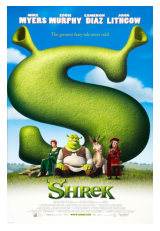

In [ ]:
#Abrimos esa imagen descargada y la presentamos como resultado del recomendador
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('.../imagenes/000001.jpg') #ruta y nombre del archivo de imagen
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Con pequeñas modificaciones al código y el armado de una función recursiva, se podría lograr que el recomenador muestre las imágenes de las 20 películas